In [1]:
# Plot inefficiency against livetime
# Somewhat based on PlotModuleEfficiency and PlotFailures
# Relies on Scripts/SubmitLiveTime.sh and RunLiveTime.sh on the VMs.

In [2]:
# External
# import os
# import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Internal
sys.path.append(os.path.abspath("../PyMacros"))
import Utils as ut
from mu2etools import read_data as rd

In [3]:
# def PoissonUncertainty(data_):
#     n_failures = np.sum(data_["Failures"])
#     n_total = np.sum(data_["Total"])
#     return np.sqrt(n_failures) / (n_total)

In [4]:
# # Get the tags, livetime, efficiency information in a single dataframe. 
# # This approach gives the most flexibility
# def GetData(tags_, PEs=10, layers=3, particle="all", cut="no_track_cuts", dataset="MDC2020ae"):
    
#     print(f"---> Getting data for {len(tags_)} files, {layers}/4 layers, {particle}, {cut}, {dataset}")

#     output_ = pd.DataFrame(columns=["tag", "livetime", "total", "failures", "running_livetime", "running_total", "running_failures"])

#     # Get ineffiency data 
#     ineffFile =  f"../Txt/{dataset}/AugustCRVMeeting/FourthPass/concatenated/results/results_{particle}_{PEs}PEs{layers}Layers_{cut}.csv"
#     ineffData_ = pd.read_csv(ineffFile)

#     # Accumulated results
#     runningLiveTime = 0
#     runningTotal = 0
#     runningFailures = 0
    
#     # Iterate through tags in 10 combinations
#     for i in range(10):

#         liveTime = 0 
#         total = 0 
#         failures = 0 
        
#         # Randomise
#         np.random.shuffle(tags_)
#         for tag in tags_:
    
#             # Get live time
    
#             # Read live time file
#             liveTimeFile = f"../Txt/{dataset}/LiveTime/mcs.mu2e.CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.{tag}.livetime" #  for tag in tags_]
            
#             # print(liveTimeFile)
#             # # liveTimeData_ = pd.DataFrame(columns=["livetime"])
    
#             liveTime = 767.1171758854167
            
#             try:
#                 liveTimeData_ = pd.read_csv(liveTimeFile) 
#                 # Check if the DataFrame is empty
#                 if liveTimeData_.empty:
#                     liveTime += 767.1171758854167
#                 else: 
#                     liveTime += np.sum(liveTimeData_.iloc[:, 0])
#             except:
#                 print("Exception...")
    
#             # Get total live time
#             # thisLiveTime = np.sum(liveTimeData_.iloc[:, 0])
            
#             # Get inefficiency
#             total += ineffData_[ineffData_["Tag"] == tag]["Total"].values[0]
#             failures += ineffData_[ineffData_["Tag"] == tag]["Failures"].values[0]
            
#             # liveTime += thisLiveTime
        


#         runningLiveTime += liveTime
#         runningTotal += total
#         runningFailures += failures
        
#         # Append to the DataFrame using .loc
#         output_.loc[len(output_)] = [tag, liveTime, total, failures, runningLiveTime, runningTotal, runningFailures]

#     return output_

In [5]:
# Get the tags, livetime, efficiency information in a single dataframe. 
# This approach gives the most flexibility
def GetData(tags_, PEs=10, layers=3, particle="all", cut="crv_44_trigger", dataset="MDC2020ae"):
    
    print(f"---> Getting data for {len(tags_)} files, {layers}/4 layers, {particle}, {cut}, {dataset}")

    output_ = pd.DataFrame(columns=["index", "running_livetime", "running_total", "running_failures"])

    # Get ineffiency data 
    ineffFile =  f"../Txt/{dataset}/Summer24/Pass8/concatenated/results/results_{particle}_{PEs}PEs{layers}Layers_{cut}.csv"
    ineffData_ = pd.read_csv(ineffFile)

    # runningLiveTime = 0
    # runningTotal = 0
    # runningFailures = 0

    # Iterate through tags in 10 combinations
    for i in range(10):
        
        # Accumulated results
        index = 1
        runningLiveTime = 0
        runningTotal = 0
        runningFailures = 0
        
        # Randomise
        np.random.shuffle(tags_) 
            
        for tag in tags_:
    
            # Read live time file
            liveTimeFile = f"../Txt/{dataset}/LiveTime/mcs.mu2e.CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.{tag}.livetime" #  for tag in tags_]
    
            liveTime = 767.1171758854167 # the mean in case of unstaged file
        
            try:
                liveTimeData_ = pd.read_csv(liveTimeFile) 
                # Check if the DataFrame is empty
                if not liveTimeData_.empty:
                    liveTime = np.sum(liveTimeData_.iloc[:, 0])
            except:
                print("Exception...")
    
            # Get total live time
            # thisLiveTime = np.sum(liveTimeData_.iloc[:, 0])
            
            # Get inefficiency
            total = ineffData_[ineffData_["Tag"] == tag]["Total"].values[0]
            failures = ineffData_[ineffData_["Tag"] == tag]["Failures"].values[0]
            
            # liveTime += thisLiveTime
            if (liveTime >= 0) & (total >= 0) & (failures >= 0):
                runningLiveTime += liveTime
                runningTotal += total
                runningFailures += failures
            else:
                raise ValueError("---> Counts are negative!")
        
            # Append to the DataFrame using .loc
            output_.loc[len(output_)] = [index, runningLiveTime, runningTotal, runningFailures]

            index += 1

    return output_.groupby("index").mean().reset_index()

In [6]:
# # Config


In [7]:
# Get file list
defname = "nts.sgrant.CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.root"
# fileList_ = rd.get_file_list(defname)

fileList_ = [] 
# Open the file and read line by line
with open("../Txt/FileLists/MDC2020aeOnExpData.txt", 'r') as file:
    fileList_= file.readlines()
# remove newline characters from each line
fileList_ = [line.strip() for line in fileList_]

# Get tags
tags_ = [ut.ExtractTag(fileName) for fileName in fileList_]

In [8]:
PEs=10
layers=3
particle="all"

# Try 10 combinations of tags
# for i in range(10):
#     np.random.shuffle(tags_)
data_crv_trigger_ = GetData(tags_, PEs=PEs, layers=layers, particle=particle, cut="crv_44_trigger")
data_trk_crv_trigger_ = GetData(tags_, PEs=PEs, layers=layers, particle=particle, cut="trk_crv_44_trigger")
# print(np.mean(data_track_cuts_["livetime"]))
# print(data_no_track_cuts_)

---> Getting data for 96 files, 3/4 layers, all, crv_44_trigger, MDC2020ae
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
---> Getting data for 96 files, 3/4 layers, all, trk_crv_44_trigger, MDC2020ae
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...
Exception...


In [9]:
def PlotGraphErrors(x, y, xerr=[], yerr=[], title=None, xlabel=None, ylabel=None, colour="blue", fout="scatter.png", NDPI=300):

   # Create a scatter plot with error bars using NumPy arrays 

    # Create figure and axes
    fig, ax = plt.subplots()

    # Plot scatter with error bars
    if len(xerr)==0: xerr = [0] * len(x) # Sometimes we only use yerr
    if len(yerr)==0: yerr = [0] * len(y) # Sometimes we only use yerr

    if len(x) != len(y): print("Warning: x has length", len(x),", while y has length", len(y))

    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', color=colour, markersize=4, ecolor=colour, capsize=2, elinewidth=1, linestyle='None')

    # Add a line at 99.99% efficiency
    if True:
        ax.text(15, 1.05e-4, "99.99% efficiency", color="gray", zorder=1) #, transform=ax.transAxes, ha='right')
        ax.axhline(y=1e-4, color='gray', linestyle='--', zorder=1)
        
    # Set title, xlabel, and ylabel
    ax.set_title(title, fontsize=15, pad=10)
    ax.set_xlabel(xlabel, fontsize=13, labelpad=10) 
    ax.set_ylabel(ylabel, fontsize=13, labelpad=10) 

    # Set font size of tick labels on x and y axes
    ax.tick_params(axis='x', labelsize=13)  # Set x-axis tick label font size
    ax.tick_params(axis='y', labelsize=13)  # Set y-axis tick label font size

    ut.ScientificNotation(ax)

    # Display and save
    plt.tight_layout()
    plt.savefig(fout, dpi=NDPI, bbox_inches="tight")
    plt.show()
    print("---> Written", fout)

    # Clear memory
    plt.close()

In [18]:
def PlotGraphOverlay(graphs_, title=None, xlabel=None, ylabel=None, xmin=0, xmax=-1, ymin=0, ymax=-1, labels_=[], fout="scatter.png", effLine=False, log=False, includeBlack=False, NDPI=300):
    
    # Create figure and axes
    fig, ax = plt.subplots()

    # Iterate over each pair of xy lists
    for i, (label, data_) in enumerate(graphs_.items()):

        colour = ut.colours[i+1]
        if includeBlack: colour = ut.colours[i]

        # ax.errorbar(data_["x"], data_["y"], xerr=data_["xerr"], yerr=data_["yerr"], fmt='o', color=colour, markersize=4, ecolor=colour, capsize=2, elinewidth=1, linestyle='-',label=label)
        # Plot the main data line
        ax.plot(data_["x"], data_["y"], color=colour, label=label, linestyle='-', linewidth=1)
        # Create error bands for y-error
        ax.fill_between(data_["x"], data_["y"] - data_["yerr"], data_["y"] + data_["yerr"], color=colour, alpha=0.3)

    if log: 
        ax.set_yscale("log")

    # Set title, xlabel, and ylabel
    ax.set_title(title, fontsize=15, pad=10)
    ax.set_xlabel(xlabel, fontsize=13, labelpad=10)
    ax.set_ylabel(ylabel, fontsize=13, labelpad=10)

    # Set font size of tick labels on x and y axes
    ax.tick_params(axis='x', labelsize=13)  
    ax.tick_params(axis='y', labelsize=13)  

    if (ymax > ymin):
        ax.set_ylim(ymin, ymax)

    if (xmax > xmin):
        ax.set_xlim(xmin, xmax)
        
    # Add a line at 99.99% efficiency
    if effLine:
        ax.text(12, 1.05e-4, "99.99% efficiency", color="gray", fontsize=13) #, transform=ax.transAxes, ha='right')
        ax.axhline(y=1e-4, color='gray', linestyle='--')
        # ax.axvline(x=graphs_["Track cuts"]["x"][graphs_["Track cuts"]["y"] <= (1e-4 - graphs_["Track cuts"]["yerr"])], color='gray', linestyle='--')
        # print(graphs_["Track cuts"]["x"][graphs_["Track cuts"]["y"] <= (1e-4 - graphs_["Track cuts"]["yerr"])])

    ut.ScientificNotation(ax)
    
    ax.legend(loc="best", frameon=False, fontsize=13) # , markerscale=5)

    fig.tight_layout()
    fig.show()
    
    # Save the figure
    fig.savefig(fout, dpi=NDPI, bbox_inches="tight")
    print("---> Written", fout)

    # Clear memory
    # plt.close()
    # plt.clr()

    return

In [11]:
print(f"Total livetime is {data_crv_trigger_["running_livetime"][-1:].values[0]:.2f} seconds.")
print(f"Total livetime is {data_trk_crv_trigger_["running_livetime"][-1:].values[0]/3600:.2f} hours.")

print(data_crv_trigger_)
print(len(data_trk_crv_trigger_["running_livetime"]))
# This is the result from the other script... 
# 45884.2 sec. I'm more inclined to think this value is wrong to be honest. 

Total livetime is 73639.14 seconds.
Total livetime is 20.46 hours.
    index  running_livetime  running_total  running_failures
0     1.0        764.112528         6349.1               0.0
1     2.0       1504.054398        12451.3               0.0
2     3.0       2275.147328        18785.2               0.0
3     4.0       3046.192385        25157.5               0.0
4     5.0       3817.272277        31521.3               0.2
..    ...               ...            ...               ...
91   92.0      70554.799762       584570.5               5.8
92   93.0      71325.868743       591004.1               5.9
93   94.0      72096.998247       597373.5               5.9
94   95.0      72868.085105       603764.0               5.9
95   96.0      73639.140907       610163.0               6.0

[96 rows x 4 columns]
96


In [12]:
# from statsmodels.stats.proportion import proportion_confint

# # Number of trials and failures
# N = 7088
# k = 0

# N = 695190
# k = 45

# # Compute the Wilson score interval
# ci_low, ci_high = proportion_confint(k, N, method='wilson')

# # print(f"95% CI: [{ci_low:.10f}, {ci_high:.10f}]")
# print(f"95% CI: [{ci_low}, {ci_high}]")

---> Written ../Images/MDC2020ae/LiveTime/gr_livetime_overlay_3.png
5.774432080469039


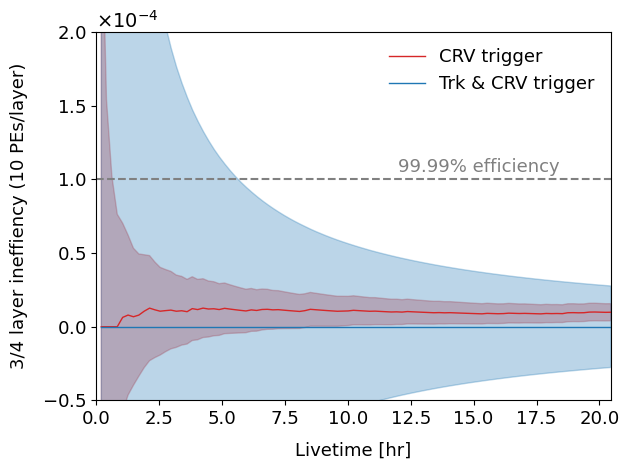

In [20]:
# Uncertainties
# I think a conservative Wilson estimate is the best bet. 
# The other three look remarkably similar, and return zero uncertainty at low N and zero k, which is just a bad estimate.

def PoissonUncertainty(data_):
    n_failures = data_["running_failures"]
    n_total = data_["running_total"]
    return np.sqrt(n_failures) / (n_total)

def BinomialUncertainty(data_):
    # What happens if the number of failures gets close to zero?
    n_failures = data_["running_failures"]
    n_total = data_["running_total"]
    q = n_failures / n_total # binomial
    se_q = np.sqrt(q * (1 - q) / n_total)
    return se_q

from statsmodels.stats.proportion import proportion_confint
def WilsonUncertainty(data_, conservative=True):
    # What happens if the number of failures gets close to zero?
    k = data_["running_failures"]
    N = data_["running_total"]
    lower, upper = proportion_confint(k, N, method="wilson")
    point = k/N
    if conservative: 
        return abs((upper - point) / 2)
    else:
        return abs((lower - point) / 2)

# PlotGraphErrors(x=(data_["running_livetime"]/3600)
#                 , y=(data_["running_failures"]/data_["running_total"])
#                 # , yerr=np.sqrt(data_["running_failures"]) / (data_["running_total"]) # Poisson
#                 , yerr=BinomialUncertainty(data_) 
#                 , xlabel="Livetime [hr]", ylabel=f"{layer}/4 layer ineffiency")

# PlotGraphErrors(x=(data_["running_livetime"]/3600)
#                 , y=(data_["running_failures"]/data_["running_total"])
#                 # , yerr=np.sqrt(data_["running_failures"]) / (data_["running_total"]) # Poisson
#                 , yerr=PoissonUncertainty(data_) 
#                 , xlabel="Livetime [hr]", ylabel=f"{layer}/4 layer ineffiency")


# cut="no_track_cuts"

# PlotGraphErrors(x=(data_no_track_cuts_["running_livetime"]/3600)
#                 , y=(data_no_track_cuts_["running_failures"]/data_no_track_cuts_["running_total"])
#                 # , yerr=np.sqrt(data_["running_failures"]) / (data_["running_total"]) # Poisson
#                 , yerr=WilsonUncertainty(data_no_track_cuts_, conservative=True) 
#                 , colour=ut.colours[1]
#                 , xlabel="Livetime [hr]"
#                 , ylabel=f"{layers}/4 layer ineffiency"
#                 , title=f"{PEs} PEs/layer, no track cuts")

# PlotGraphErrors(x=(data_track_cuts_["running_livetime"]/3600)
#                 , y=(data_track_cuts_["running_failures"]/data_track_cuts_["running_total"])
#                 # , yerr=np.sqrt(data_["running_failures"]) / (data_["running_total"]) # Poisson
#                 , yerr=WilsonUncertainty(data_track_cuts_, conservative=True) 
#                 , colour=ut.colours[1]
#                 , xlabel="Livetime [hr]"
#                 , ylabel=f"{layers}/4 layer ineffiency"
#                 , title=f"{PEs} PEs/layer, track cuts")
# \data_trk_crv_trigger_

graphs_ = { "CRV trigger" : 
           { "x" : data_crv_trigger_["running_livetime"]/3600
            , "xerr" : [0]*len(data_crv_trigger_["running_livetime"])
            , "y" : data_crv_trigger_["running_failures"]/data_crv_trigger_["running_total"]
            , "yerr" : WilsonUncertainty(data_crv_trigger_, conservative=True) } 
           , "Trk & CRV trigger" : 
           { "x" : data_trk_crv_trigger_["running_livetime"]/3600
            , "xerr" : [0]*len(data_trk_crv_trigger_["running_livetime"])
            , "y" : data_trk_crv_trigger_["running_failures"]/data_trk_crv_trigger_["running_total"]
            , "yerr" : WilsonUncertainty(data_trk_crv_trigger_, conservative=True) } 
          }
           


PlotGraphOverlay(graphs_
                , xlabel="Livetime [hr]"
                , ylabel=f"{layers}/4 layer ineffiency (10 PEs/layer)"
                , ymin = -5e-5, ymax=2e-4
                , xmin = 0, xmax=20.46
                , effLine=True
                , fout="../Images/MDC2020ae/LiveTime/gr_livetime_overlay_3.png")

# PlotGraphOverlay(graphs_
#                 , xlabel="Livetime [hr]"
#                 , ylabel=f"{layers}/4 layer ineffiency"
#                 , title=f"{PEs} PEs/layer, track cuts"
#                 , ymin = 0, ymax=1e-3
#                 , xmin = 0, xmax=20.46
#                 , effLine=True
#                 , log=True)

print(np.min(graphs_["Trk & CRV trigger"]["x"][graphs_["Trk & CRV trigger"]["y"] <= (1e-4 - graphs_["Trk & CRV trigger"]["yerr"])])) #$[data_track_cuts_["Track cuts"]["y"] <= (1e-4 - graphs_["Track cuts"]["yerr"])]
# PlotGraphErrors(x=(data_["running_livetime"]/3600)
#                 , y=(data_["running_failures"]/data_["running_total"])
#                 # , yerr=np.sqrt(data_["running_failures"]) / (data_["running_total"]) # Poisson
#                 , yerr=WilsonUncertainty(data_, conservative=False) 
#                 , xlabel="Livetime [hr]", ylabel=f"{layer}/4 layer ineffiency")


In [ ]:
print(len(graphs_["Track cuts"]["x"]))